Prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation à partir de relevés de la ville seattle
TARGET : SiteEnergyUseWN(kBtu) & GHGEmissions <br>
Obtenir un modèle pour l'énergie avec un R2 de plus de 0,75 sur le jeu de test et plus de 0,7 pour le CO2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from category_encoders import MEstimateEncoder
import sklearn
sklearn.set_config(transform_output="pandas")
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

# 0. Nettoyage

## 0.1 Import du df et nettoyage

In [2]:
def nettoyage():
    df = pd.read_csv('2016-building-energy-benchmarking.csv')
    # drop any multi family buildings, only non residential are targeted
    propertytype_dropped = ['Mid-Rise Multifamily','High-Rise Multifamily','Low-Rise Multifamily','Residence Hall']
    df = df[~df.PrimaryPropertyType.isin(propertytype_dropped)]
    buildingtype_dropped = ['Multifamily MR (5-9)','Multifamily HR (10+)','Multifamily LR (1-4)']
    df = df[~df.BuildingType.isin(buildingtype_dropped)]
    # col homogoneous or unable to use # here it is decided to drop the EnergyStar Score ?
    cols_to_drop = ['CouncilDistrictCode','PropertyName','OSEBuildingID', 'City', 'State', 'DataYear', 'ZipCode', 'TaxParcelIdentificationNumber',
'YearsENERGYSTARCertified', 'Comments', 'DefaultData','Outlier','ENERGYSTARScore','Address']
    df.drop(columns=cols_to_drop, inplace=True)
    # too many missing data on these rows
    df.drop(index=[578,2670,30,1361,304],inplace=True)
    # renaming PropertyGFABuilding(s) to avoid bugs for the anova
    df.rename(columns={"PropertyGFABuilding(s)":"PropertyGFABuildings"}, inplace=True)
    # SiteEUIWN(kBtu/sf) imputing data by the coeff diff between WN and not WN
    df.loc[563,'SiteEUIWN(kBtu/sf)'] = df['SiteEUIWN(kBtu/sf)'].mean() / df['SiteEUI(kBtu/sf)'].mean() * 39.5
    df.loc[563,'SiteEnergyUseWN(kBtu)'] = df['SiteEnergyUse(kBtu)'].mean() / df['SiteEnergyUseWN(kBtu)'].mean() * 5177270.5
    # LargestPropertyUseType  not filled in , imputing by research on the activity of the company
    df.loc[1147,'LargestPropertyUseType'] = 'Hotel'
    df.loc[2414,'LargestPropertyUseType'] = 'Office'
    df.loc[2459,'LargestPropertyUseType'] = 'Restaurant'
    df.loc[353,'LargestPropertyUseType'] = 'Self-Storage Facility'
    # LargestPropertyUseTypeGFA not filled in, imputing the real GFA if one building else dividing totalGFA by number of buildings
    df.loc[1147,'LargestPropertyUseTypeGFA'] = 61721
    df.loc[2414,'LargestPropertyUseTypeGFA'] = 48350
    df.loc[2459,'LargestPropertyUseTypeGFA'] = 28800
    df.loc[353,'LargestPropertyUseTypeGFA'] = 55722
    # missing data from compliance
    idx_missingdata = df[df['ComplianceStatus'] ==  'Missing Data'].index
    df.drop(index=idx_missingdata, inplace=True)
    # fixing typos issues within the neighborhood column
    df.Neighborhood = df.Neighborhood.map(lambda x: x.lower())
    df.loc[3370,'Neighborhood'] = 'delridge'
    df.loc[1328,'PrimaryPropertyType'] = 'Hotel'
    # pour les WN non renseignés, imputation par multiplication de leur normal par le ratio de la moyenne
    for idx in df[df['SiteEUIWN(kBtu/sf)'] == 0].index :
        df.loc[idx,'SiteEUIWN(kBtu/sf)'] = (df['SiteEUIWN(kBtu/sf)'].mean() / df['SiteEUI(kBtu/sf)'].mean()) * df.loc[idx,'SiteEUI(kBtu/sf)']
    # GFA columns : imputing NaN by 0
    df['SecondLargestPropertyUseTypeGFA'] = df['SecondLargestPropertyUseTypeGFA'].fillna(0)
    df['ThirdLargestPropertyUseTypeGFA'] = df['ThirdLargestPropertyUseTypeGFA'].fillna(0)
    # SiteEnergyUseWN not filled in , mean imputing because weathered was filled in
    for idx in df[df['SiteEnergyUseWN(kBtu)'] == 0].index:
        df.loc[idx,'SiteEnergyUseWN(kBtu)'] = (df['SiteEUIWN(kBtu/sf)'].mean() / df['SiteEUI(kBtu/sf)'].mean()) * df.loc[idx,'SiteEnergyUse(kBtu)']
    # incorrect number of buildings of 0
    idx_build0 = df[df.NumberofBuildings == 0].index
    for idx in idx_build0:
        df.loc[idx,'NumberofBuildings'] = 1
    return df

In [3]:
def preprocess(df):
    # skyscraper feature
    #df['skyscraper'] = df.NumberofFloors > 8
    # OH functions ,if it is labo or a campus/univeristy or an hospital

    # laboratoire ?
    def is_labo(x):
        if x['PrimaryPropertyType'] == 'Laboratory':
            return 1
        elif x['LargestPropertyUseType'] == 'Laboratory'  :
            return 1
        else :
            return 0

    df['is_laboratory'] = df.apply(is_labo, axis=1)

    # campus ou université ?
    def is_campus(x):
        if x['BuildingType'] == 'Campus':
            return 1
        elif x['PrimaryPropertyType'] == 'University':
            return 1
        else :
            return 0

    df['is_campus'] = df.apply(is_campus, axis=1)

    # hopital ?
    def is_hospital(x):
        if x == 'Hospital':
            return 1
        else :
            return 0
    #df['is_hospital'] = df.PrimaryPropertyType.map(is_hospital)
    #df.loc[2482, 'is_hospital'] = False # cas particulier

    # decennie est bof, essayer par trentaine d'année  ?
    df['decennie'] = df.YearBuilt.map(lambda x :  (2017 - x) // 10 ) + 1

    # calcul du pourcentage de source d'énergie
    def p_gas(x):
        if x['SiteEnergyUseWN(kBtu)'] != 0:
            return x['NaturalGas(kBtu)'] / x['SiteEnergyUseWN(kBtu)'] *100
        else :
            return 0
    df['p_gas'] = df.apply(p_gas,axis=1)

    def p_elec(x):
        if x['SiteEnergyUseWN(kBtu)'] != 0:
            return x['Electricity(kBtu)'] / x['SiteEnergyUseWN(kBtu)'] *100
        else :
            return 0
    df['p_elec'] = df.apply(p_elec,axis=1)
    def p_steam(x):
        if x['SiteEnergyUseWN(kBtu)'] != 0:
            return x['SteamUse(kBtu)'] / x['SiteEnergyUseWN(kBtu)'] *100
        else :
            return 0
    df['p_steam'] = df.apply(p_steam,axis=1)
    # colonne de différence entre WN et normal
    df['WN_ratio'] = df['SiteEUIWN(kBtu/sf)'] / df['SiteEUI(kBtu/sf)']
    # get_dummies sur largestype
    #df = pd.get_dummies(df,columns=['LargestPropertyUseType'])
    # outlier ? 35 ?
    df.drop(index=[3274,35], inplace = True)
    return df

In [4]:
df=preprocess(nettoyage())

## 0.2 Modification des Use Type et GFA's ( METTRE TOUT LE CODE DANS UNE FONCTION A APPELER )


In [5]:
# colonnes sur lesquelles on va transformer
cols_to_transform = ['LargestPropertyUseType','LargestPropertyUseTypeGFA','SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']
# DataFrame de travail
df_merging = df[cols_to_transform].copy()

In [6]:
# bins
list_type = ['Data Center','Fitness Center/Health Club/Gym','Office', 'Non-Refrigerated Warehouse', 'K-12 School', 'Retail Store',
       'Other', 'Hotel', 'Worship Facility', 'Distribution Center',
       'Supermarket/Grocery Store', 'Medical Office', 'Other - Recreation',
       'Parking', 'Self-Storage Facility', 'College/University',
       'Other - Entertainment/Public Assembly', 'Senior Care Community',
       'Laboratory', 'Restaurant', 'Refrigerated Warehouse',
       'Social/Meeting Hall', 'Hospital (General Medical & Surgical)',
       'Multifamily Housing', 'Manufacturing/Industrial Plant',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Strip Mall']
# mapping des colonnes UseType avec la liste de dessus
def categs1(x):
    if x in list_type:
        return x
    else :
        return 'Other'
df_merging['categs1'] = df_merging.LargestPropertyUseType.map(categs1)

def categs2(x):
    if x in list_type:
        return x
    elif x!= 0 :
        return 'Other'
df_merging['categs2'] = df_merging.SecondLargestPropertyUseType.map(categs2)

def categs3(x):
    if x in list_type:
        return x
    elif x!= 0 :
        return 'Other'
df_merging['categs3'] = df_merging.ThirdLargestPropertyUseType.map(categs3)

In [7]:
# OH
df_merging = pd.get_dummies(df_merging,columns=['categs1'])
# liste des colonnes OH'ed
largest_cols = []
for col in df_merging.columns :
    if 'categs1_' in col:
        largest_cols.append(col)
# !!! code dégueu :  boucle qui assigne la valeur GFA au type d'Use
for col in largest_cols:
    def transformGFA(x):
        if x[col] == True:
            return x['LargestPropertyUseTypeGFA']
        else :
            return 0
    df_merging[col+'1'] = df_merging.apply(transformGFA, axis=1)

In [8]:
# belote pour le second

df_merging = pd.get_dummies(df_merging,columns=['categs2'])

second_cols = []
for col in df_merging.columns :
    if 'categs2_' in col:
        second_cols.append(col)
for col in second_cols:
    def secondtransformGFA(x):
        if x[col] == True:
            return x['SecondLargestPropertyUseTypeGFA']
        else :
            return 0
    df_merging[col+'2'] = df_merging.apply(secondtransformGFA, axis=1)

In [9]:
# rebelote , faire une fonction serait pas mal ....
df_merging = pd.get_dummies(df_merging,columns=['categs3'])

third_cols = []
for col in df_merging.columns :
    if 'categs3_' in col:
        third_cols.append(col)
for col in third_cols:
    def thirdtransformGFA(x):
        if x[col] == True:
            return x['ThirdLargestPropertyUseTypeGFA']
        else :
            return 0
    df_merging[col+'3'] = df_merging.apply(thirdtransformGFA, axis=1)

In [10]:
# somme des valeurs des GFa/UseType en une colonne
for categ in list_type:
        if 'categs3_'+categ+'3' in df_merging.columns :
            if 'categs1_'+categ+'1' in df_merging.columns:
                if 'categs2_'+categ+'2' in df_merging.columns:
                    df_merging[categ] = df_merging['categs1_'+categ+'1'] +  df_merging['categs2_'+categ+'2'] + df_merging['categs3_'+categ+'3']
                else :
                    df_merging[categ] =  df_merging['categs1_'+categ+'1'] + df_merging['categs3_'+categ+'3']
            elif 'categs2_'+categ+'2' in df_merging.columns:
                    df_merging[categ] = df_merging['categs2_'+categ+'2'] + df_merging['categs3_'+categ+'3']
            else :
                df_merging[categ] = df_merging['categs3_'+categ+'3']
        elif 'categs2_'+categ+'2' in df_merging.columns :
            if 'categs1_'+categ+'1' in df_merging.columns:
                df_merging[categ] = df_merging['categs1_'+categ+'1'] +  df_merging['categs2_'+categ+'2']
            else :
                df_merging[categ] = df_merging['categs2_'+categ+'2']
        else :
            df_merging[categ] = df_merging['categs1_'+categ+'1']

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_11576\3487616290.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merging[categ] = df_merging['categs1_'+categ+'1'] +  df_merging['categs2_'+categ+'2'] + df_merging['categs3_'+categ+'3']
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_11576\3487616290.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merging[categ] = df_merging['categs1_'+categ+'1'] +  df_merging['categs2_'+categ+'2'] + df_merging['categs3_'+categ+'3']
C:\Users\Utilisateur\AppData\Local\Temp\ipykerne

In [11]:
# ajout de ces colonnes au df principal
df = df.merge(df_merging[list_type], left_index=True, right_index=True, how='outer')

## 0.3 Colonne Etages/Surface

In [12]:
df.NumberofFloors = df.NumberofFloors + 1

In [13]:
df['floor_building'] =   df.NumberofFloors /  df.NumberofBuildings * df.PropertyGFABuildings

In [14]:
np.isinf(df['floor_building'].values).any()

False

In [15]:
stats.pearsonr(df['SiteEnergyUseWN(kBtu)'],df['floor_building'])

PearsonRResult(statistic=0.3422661238718632, pvalue=8.008086581330382e-46)

## 0.4 Colonne Ratio decennie et GFABuildings

In [16]:
 df['ratio_GFAdecennie'] =  df['PropertyGFABuildings'] / df['decennie']
 stats.pearsonr( df['ratio_GFAdecennie'], df['SiteEnergyUse(kBtu)'])

PearsonRResult(statistic=0.4939915008938631, pvalue=1.3536302766741733e-100)

# 1. EDA

In [17]:
df.describe(include ='all')

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,...,Restaurant,Refrigerated Warehouse,Social/Meeting Hall,Hospital (General Medical & Surgical),Multifamily Housing,Manufacturing/Industrial Plant,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Strip Mall,floor_building,ratio_GFAdecennie
count,1623,1623,1623,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1.623000e+03,1623.000000,...,1623.000000,1623.000000,1623.000000,1.623000e+03,1623.000000,1623.000000,1623.000000,1623.000000,1.623000e+03,1.623000e+03
unique,5,20,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NonResidential,Small- and Mid-Sized Office,downtown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1433,291,356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,47.615395,-122.333076,1961.868762,1.137400,5.154652,1.133305e+05,13189.457794,...,581.269871,479.824399,184.394948,4.276194e+03,914.300062,212.905730,164.792976,320.123845,1.169724e+06,3.319688e+04
std,NaN,NaN,NaN,0.048115,0.024540,32.725920,1.157285,6.636882,1.934699e+05,42795.282265,...,4063.564915,7927.631642,2170.424024,6.611172e+04,12829.145674,3973.460564,2508.132536,6018.664487,5.902557e+06,8.083713e+04
min,NaN,NaN,NaN,47.499170,-122.411820,1900.000000,1.000000,1.000000,1.128500e+04,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,9.266400e+03,6.060000e+02
25%,NaN,NaN,NaN,47.584690,-122.343260,1930.000000,1.000000,2.000000,2.940850e+04,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,7.776000e+04,4.404131e+03
50%,NaN,NaN,NaN,47.612170,-122.333050,1965.000000,1.000000,3.000000,4.906600e+04,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.477560e+05,8.636250e+03
75%,NaN,NaN,NaN,47.648655,-122.322110,1989.000000,1.000000,5.000000,1.042255e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,4.106775e+05,2.499232e+04


Valeurs Nulles

In [ ]:
# to drop : OSEBuildingID, City, State, DataYear, ZipCode, TaxParcelIdentificationNumber,
#       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
#       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
#       'YearsENERGYSTARCertified', 'Comments'
# pending : Adress
# ? ? : PropertyName,
# To transform : ?  : Neighborhood, Latitude, Longitude, by a K-means ?
# YearBuilt : refaire des catégories ( ancien batiment, ? ,  récent, neuf) ?
# NumberofBuildings  , regarder si c'est proportionnel
#

## 1.1 Analyse Univariée

Number of Floors

In [ ]:
df.NumberofFloors.value_counts()

In [ ]:
sns.boxplot(df.NumberofFloors)

In [ ]:
df[df.NumberofFloors > 40 ].index

Number of Buildings

In [ ]:
df.NumberofBuildings.value_counts()

In [ ]:
df[df.NumberofBuildings > 5].index

PropertyGFA

In [ ]:
plt.boxplot(df.PropertyGFATotal, vert=False)

In [ ]:
df[df.PropertyGFATotal > 1500000].sort_values(by='PropertyGFATotal')

PropertyGFAParking

In [ ]:
df.PropertyGFAParking.value_counts()

In [ ]:
sns.boxplot(df['PropertyGFAParking'])

In [ ]:
df[df.PropertyGFAParking >  200000 ].index

PropertyGFABuilding(s)

In [ ]:
df[df['PropertyGFABuildings'] > 1500000].sort_values(by='PropertyGFABuildings', ascending=False).index

SiteEUI(kBtu/sf)

In [ ]:
sns.boxplot(df['SiteEUI(kBtu/sf)'])

In [ ]:
df[df['SiteEUI(kBtu/sf)'] > 500 ].sort_values(by='SiteEUI(kBtu/sf)', ascending=False).index

SiteEUIWN(kBtu/sf)

In [ ]:
sns.boxplot(df['SiteEUIWN(kBtu/sf)'])

In [ ]:
df[df['SiteEUIWN(kBtu/sf)'] > 500 ].sort_values(by='SiteEUIWN(kBtu/sf)', ascending=False).index

 'SiteEnergyUse(kBtu)',

In [ ]:
sns.boxplot(df['SiteEnergyUse(kBtu)'])

In [ ]:
df[df['SiteEnergyUse(kBtu)'] > 200000000 ].sort_values(by='SiteEnergyUse(kBtu)', ascending=False).index

'SteamUse(kBtu)'

In [ ]:
sns.boxplot(df['SteamUse(kBtu)'])

In [ ]:
df[df['SteamUse(kBtu)'] > 20000000 ].sort_values(by='SteamUse(kBtu)', ascending=False).index

In [ ]:
df[df['SteamUse(kBtu)'] == 0].shape

Electricity(kWh)

In [ ]:
sns.boxplot(df["Electricity(kWh)"])

In [ ]:
df[df['Electricity(kWh)'] > 25000000 ].sort_values(by='Electricity(kWh)', ascending=False).index

Natural Gas (therms and kBtu)

In [ ]:
sns.boxplot(df['NaturalGas(therms)'])

In [ ]:
df[df['NaturalGas(therms)'] > 500000 ].sort_values(by='NaturalGas(therms)', ascending=False).index

ComplianceStatus

In [ ]:
df.ComplianceStatus.value_counts()

TotalGHGEmissions & GHGEmissionsIntensity

In [ ]:
sns.boxplot(df['TotalGHGEmissions'])

In [ ]:
df[df['TotalGHGEmissions'] > 5000 ].sort_values(by='TotalGHGEmissions', ascending=False).index

In [ ]:
sns.boxplot(df['GHGEmissionsIntensity'])

In [ ]:
df[df['GHGEmissionsIntensity'] > 14 ].sort_values(by='GHGEmissionsIntensity', ascending=False).index

In [ ]:
sns.boxplot(df[df.BuildingType.isin(['Campus','Hospital'])]['GHGEmissionsIntensity'].values)

In [ ]:
df.PrimaryPropertyType.unique()

In [ ]:
df.loc[df.PrimaryPropertyType.isin(['Mixed Use Property'])].sort_values(by='GHGEmissionsIntensity', ascending = False)

## 1.2 Analyse Bivariée

In [ ]:
def boxplot_test(col,target, violin = False):
  print(f"\n Distribution de {target} et  {col}")
  freq_col = pd.DataFrame(df[[target,col]])
  freq_col[col] = freq_col[col].astype('str')
  print(df[col].value_counts())
  sns.color_palette("Set2")
  if violin :
    sns.violinplot(x=freq_col[target],y=freq_col[col], palette="pastel")
  else :
    sns.boxplot(x=freq_col[target],y=freq_col[col], palette="Set2",showfliers=False)
  plt.title(col)
  plt.show()

In [ ]:
def scatter_test(col,target):
    sns.color_palette("Set2")
    freq_col = pd.DataFrame(df[[target,col]])
    sns.scatterplot(y=freq_col[target],x=freq_col[col])
    plt.title(col)
    plt.show()

In [ ]:
# 'Latitude', 'Longitude',
cols_num = [
       'SteamUse(kBtu)','Electricity(kBtu)',
       'NaturalGas(kBtu)','PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuildings']
cols_categ = ['Neighborhood','BuildingType', 'PrimaryPropertyType','YearBuilt', 'NumberofBuildings',
       'NumberofFloors','decennie']

ord_categ = ['NumberofFloors','decennie','YearBuilt']

In [ ]:
for col_num in cols_num :
    scatter_test(col_num,'SiteEnergyUse(kBtu)')

In [ ]:
for col_categ in cols_categ :
    scatter_test(col_categ,'SiteEUI(kBtu/sf)')

In [ ]:
for col_categ in cols_categ :
    boxplot_test(col_categ,'TotalGHGEmissions')

In [ ]:
for col_ord in ord_categ :
    scatter_test(col_ord,'SiteEnergyUse(kBtu)')

In [ ]:
larg_columns = ['LargestPropertyUseType_Adult Education',
       'LargestPropertyUseType_Automobile Dealership',
       'LargestPropertyUseType_Bank Branch',
       'LargestPropertyUseType_College/University',
       'LargestPropertyUseType_Courthouse',
       'LargestPropertyUseType_Data Center',
       'LargestPropertyUseType_Distribution Center',
       'LargestPropertyUseType_Financial Office',
       'LargestPropertyUseType_Fire Station',
       'LargestPropertyUseType_Fitness Center/Health Club/Gym',
       'LargestPropertyUseType_Food Service',
       'LargestPropertyUseType_Hospital (General Medical & Surgical)',
       'LargestPropertyUseType_Hotel', 'LargestPropertyUseType_K-12 School',
       'LargestPropertyUseType_Laboratory', 'LargestPropertyUseType_Library',
       'LargestPropertyUseType_Lifestyle Center',
       'LargestPropertyUseType_Manufacturing/Industrial Plant',
       'LargestPropertyUseType_Medical Office',
       'LargestPropertyUseType_Movie Theater',
       'LargestPropertyUseType_Multifamily Housing',
       'LargestPropertyUseType_Museum',
       'LargestPropertyUseType_Non-Refrigerated Warehouse',
       'LargestPropertyUseType_Office', 'LargestPropertyUseType_Other',
       'LargestPropertyUseType_Other - Education',
       'LargestPropertyUseType_Other - Entertainment/Public Assembly',
       'LargestPropertyUseType_Other - Lodging/Residential',
       'LargestPropertyUseType_Other - Mall',
       'LargestPropertyUseType_Other - Public Services',
       'LargestPropertyUseType_Other - Recreation',
       'LargestPropertyUseType_Other - Restaurant/Bar',
       'LargestPropertyUseType_Other - Services',
       'LargestPropertyUseType_Other - Utility',
       'LargestPropertyUseType_Other/Specialty Hospital',
       'LargestPropertyUseType_Parking',
       'LargestPropertyUseType_Performing Arts',
       'LargestPropertyUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'LargestPropertyUseType_Police Station',
       'LargestPropertyUseType_Pre-school/Daycare',
       'LargestPropertyUseType_Prison/Incarceration',
       'LargestPropertyUseType_Refrigerated Warehouse',
       'LargestPropertyUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'LargestPropertyUseType_Residence Hall/Dormitory',
       'LargestPropertyUseType_Residential Care Facility',
       'LargestPropertyUseType_Restaurant',
       'LargestPropertyUseType_Retail Store',
       'LargestPropertyUseType_Self-Storage Facility',
       'LargestPropertyUseType_Senior Care Community',
       'LargestPropertyUseType_Social/Meeting Hall',
       'LargestPropertyUseType_Strip Mall',
       'LargestPropertyUseType_Supermarket/Grocery Store',
       'LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient',
       'LargestPropertyUseType_Wholesale Club/Supercenter',
       'LargestPropertyUseType_Worship Facility']

In [ ]:
for col in list_type :
    scatter_test(col,'GHGEmissionsIntensity')

# 2. OLS

In [18]:
def format_col(str):
    """
    Formate les colonnes du dataframe
    """
    str = str.replace("""'""","")
    str = str.replace("""\n""","")
    str = str.replace("""/""","")
    str = str.replace(""" ""","_")
    str = str.replace("-","_")
    str = str.replace("(","")
    str = str.replace(")","")
    str = str.replace(",","_")
    str = str.replace("&","and")
    return str

In [19]:
def ols_auto(df_ols,list_cols,target,return_last_arg1=False):
    """
    df : DataFrame cleaned up ( no NaN and categorical must be encoded)
    list_cols : List of columns  ex : list(df_ols.columns)
    target : String of the col target ex:  'target'
    return_last_arg1 : renvoi du dernier arg1 (str) pour peaufiner l'anova
    """
    # conversion en liste
    if type(list_cols) != list :
      try:
        list_cols_asList = list(list_cols)
      except:
        print("Le second argument n'est pas convertissable en Liste Python ! ")
    else:
      list_cols_asList = list_cols.copy()

    # définition du df de travail
    df_test = df_ols[list_cols_asList].copy()

    # conversion en float des colonnes concernées
    for col in df_test.columns:
        try:
            df_test.loc[:,col] = df_test[col].astype(float,errors='ignore')
        except: # !!!  fonctionnalité d'erreur non testée pas testée
            print('Error : could not convert column : ',col,' to float')
    while True :
        # A REVOIR :  pour retirer un élément à chaque itération  ( utiliser regex ou autre ? )
        # construction de l'argument 1 ( chaine de caractere) dans la fonction ols
        str2=""
        for col in list_cols_asList :
            if col == target:
                pass
            else:
                str2+= (" + " + col )
        format_str= str2[2:]
        ols_arg1 = target +" ~ "+format_str + " -1 "
        # realisation de l'ols
        test_reg = ols(ols_arg1, data=df_test).fit()
        #print(i,test_reg.pvalues.idxmax(),test_reg.pvalues.max())
        # si p value max est inférieure à 5 % , break
        if  test_reg.pvalues.max() < 0.05:
            break
        else:
            list_cols_asList.remove(test_reg.pvalues.idxmax())
    if return_last_arg1 :
      return test_reg, ols_arg1
    return test_reg

In [20]:
ols_df = df.copy()
ols_df = pd.get_dummies(ols_df, columns=['Neighborhood'], drop_first=True)
# cols unusable
cols_unusable = ['NumberofBuildings','NumberofFloors','YearBuilt','BuildingType','PrimaryPropertyType','SiteEUIWN(kBtu/sf)','LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA','PropertyGFATotal','PropertyGFAParking','PropertyGFABuildings','ListOfAllPropertyUseTypes','SiteEUI(kBtu/sf)','SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)','Latitude', 'Longitude','SiteEnergyUse(kBtu)', 'SteamUse(kBtu)','Electricity(kWh)','Electricity(kBtu)','NaturalGas(therms)','NaturalGas(kBtu)','ComplianceStatus','GHGEmissionsIntensity']
ols_df.drop(columns=cols_unusable, inplace=True)
# renaming columns to perform ols
for col in ols_df.columns:
    col_formatted = format_col(col)
    ols_df.rename(columns={col:col_formatted},inplace=True)

### 2.1 GHG : Anova

['Neighborhood','BuildingType', 'PrimaryPropertyType','YearBuilt', 'NumberofBuildings',
       'NumberofFloors',
       'PropertyGFABuilding(s)',
       'ComplianceStatus',
       'Outlier']

In [21]:
olsGHG_df = ols_df.copy()
#manually drop the SiteEnergyUsekBtu
olsGHG_df.drop(columns=['SiteEnergyUseWNkBtu'], inplace=True)

In [23]:
GHG_reg, arg1 = ols_auto(olsGHG_df,olsGHG_df.columns,'TotalGHGEmissions', return_last_arg1=True)
print(GHG_reg.summary())

                                 OLS Regression Results                                
Dep. Variable:      TotalGHGEmissions   R-squared (uncentered):                   0.914
Model:                            OLS   Adj. R-squared (uncentered):              0.912
Method:                 Least Squares   F-statistic:                              625.1
Date:                Fri, 04 Aug 2023   Prob (F-statistic):                        0.00
Time:                        08:48:23   Log-Likelihood:                         -10705.
No. Observations:                1623   AIC:                                  2.146e+04
Df Residuals:                    1596   BIC:                                  2.161e+04
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

In [24]:
# remplacement des + par , pour pouvoir intégrer ces colonnes à une liste facilement
arg1[20:-3].replace('+',"','")

" is_campus ',' p_gas ',' p_elec ',' p_steam ',' WN_ratio ',' Data_Center ',' Office ',' Non_Refrigerated_Warehouse ',' K_12_School ',' Retail_Store ',' Other ',' Hotel ',' Distribution_Center ',' SupermarketGrocery_Store ',' Medical_Office ',' Other___Recreation ',' Parking ',' CollegeUniversity ',' Other___EntertainmentPublic_Assembly ',' Senior_Care_Community ',' Laboratory ',' SocialMeeting_Hall ',' Hospital_General_Medical_and_Surgical ',' Multifamily_Housing ',' Strip_Mall ',' floor_building ',' ratio_GFAdecennie "

## 2.2 SiteEnergyUse(kBtu) : Anova

In [25]:
ols_energy_df = ols_df.copy()
ols_energy_df.drop(columns=['TotalGHGEmissions','p_gas','p_elec','p_steam'], inplace = True)

In [26]:
energy_reg, arg_energy = ols_auto(ols_energy_df,ols_energy_df.columns,'SiteEnergyUseWNkBtu',return_last_arg1=True)
print(energy_reg.summary())

                                 OLS Regression Results                                 
Dep. Variable:     SiteEnergyUseWNkBtu   R-squared (uncentered):                   0.905
Model:                             OLS   Adj. R-squared (uncentered):              0.904
Method:                  Least Squares   F-statistic:                              565.1
Date:                 Fri, 04 Aug 2023   Prob (F-statistic):                        0.00
Time:                         08:49:31   Log-Likelihood:                         -27733.
No. Observations:                 1623   AIC:                                  5.552e+04
Df Residuals:                     1596   BIC:                                  5.567e+04
Df Model:                           27                                                  
Covariance Type:             nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
----

In [27]:
arg_energy[22:-3].replace('+',"','")

" is_campus ',' decennie ',' WN_ratio ',' Data_Center ',' Office ',' Non_Refrigerated_Warehouse ',' K_12_School ',' Retail_Store ',' Other ',' Hotel ',' Distribution_Center ',' SupermarketGrocery_Store ',' Medical_Office ',' Other___Recreation ',' CollegeUniversity ',' Other___EntertainmentPublic_Assembly ',' Senior_Care_Community ',' Laboratory ',' Restaurant ',' Refrigerated_Warehouse ',' SocialMeeting_Hall ',' Hospital_General_Medical_and_Surgical ',' Multifamily_Housing ',' Strip_Mall ',' floor_building ',' ratio_GFAdecennie ',' Neighborhood_northeast "

# 3.  Predictions : TotalGHGEmissions

In [29]:
possible_features = ['floor_building', 'is_campus ',' p_gas ',' p_elec ',' p_steam ',' WN_ratio ',' Data_Center ',' Other ',' Hotel ',' SupermarketGrocery_Store ',' Medical_Office ',' Other___Recreation ',' Senior_Care_Community ',' Laboratory ',' Hospital_General_Medical_and_Surgical']
i = 0
while i < len(possible_features):
    possible_features[i] = possible_features[i].strip()
    i+=1

In [30]:
features = ['NumberofBuildings' , 'NumberofFloors' , 'is_laboratory' , 'is_hospital' , 'p_gas' , 'p_steam' , 'PropertyGFABuildings' , 'LargestPropertyUseType_SupermarketGrocery_Store' , 'LargestPropertyUseType_Senior_Care_Community' ,'LargestPropertyUseType_Data_Center' , 'LargestPropertyUseType_Hotel']
# a corriger
X_GHG = ols_df[possible_features].to_numpy()
y_GHG = ols_df['TotalGHGEmissions'].to_numpy()
X_train_GHG, X_test_GHG , y_train_GHG, y_test_GHG = train_test_split(X_GHG,y_GHG,test_size=0.2, random_state=33)

In [31]:
rf = RandomForestRegressor()
param_rf = {'n_estimators':[i for i in range(1,20,1)],
           'max_depth':[i for i in range(1,10,1)]}
regr = GridSearchCV(rf,param_grid=param_rf,scoring='r2',cv=5,refit=True)
regr.fit(X_train_GHG,y_train_GHG)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19]},
             scoring='r2')

In [32]:
regr.score(X_train_GHG,y_train_GHG)

0.9276991345110219

In [33]:
params = regr.best_params_
params

{'max_depth': 8, 'n_estimators': 10}

In [34]:
final_rf = RandomForestRegressor(n_estimators = params['n_estimators'],max_depth=params['max_depth'])
final_rf.fit(X_train_GHG,y_train_GHG)
metrics.r2_score(y_test_GHG,final_rf.predict(X_test_GHG))

0.7694118212325385

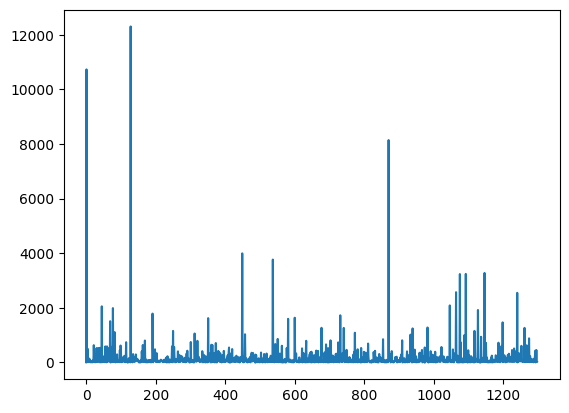

In [35]:
plt.plot(y_train_GHG)

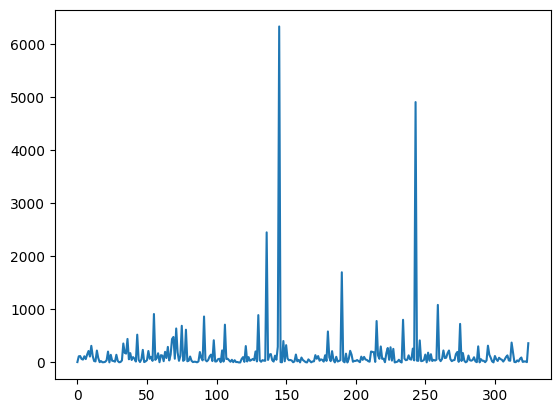

In [36]:
plt.plot(y_test_GHG)

# 4.  Prediction : SiteEnergyUsekBtu

In [37]:
possible_features_E = ['Neighborhood_northeast','floor_building',' is_campus ',' decennie ',' Data_Center ',' Office ',' Non_Refrigerated_Warehouse ',' K_12_School ',' Retail_Store ',' Other ',' Hotel ',' Distribution_Center ',' SupermarketGrocery_Store ',' Medical_Office ',' Other___Recreation ',' CollegeUniversity ',' Other___EntertainmentPublic_Assembly ',' Senior_Care_Community ',' Laboratory ',' Restaurant ',' Refrigerated_Warehouse ',' SocialMeeting_Hall ',' Hospital_General_Medical_and_Surgical ',' Multifamily_Housing ',' Strip_Mall' ]
i = 0
while i < len(possible_features_E):
    possible_features_E[i] = possible_features_E[i].strip()
    i+=1

In [38]:
#features = ['WN_ratio', 'YearBuilt' ,'NumberofBuildings', 'is_laboratory','LargestPropertyUseType_Hospital_General_Medical_and_Surgical', 'is_campus' , 'PropertyGFABuildings' , 'LargestPropertyUseType_SupermarketGrocery_Store','LargestPropertyUseType_Data_Center' , 'LargestPropertyUseType_Hotel']
# a corriger
X_energy = ols_df[possible_features_E]
y_energy = ols_df['SiteEnergyUseWNkBtu']

## 4.0 ACP

In [39]:
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression



plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs



def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


In [40]:
X_scaled = (X_energy - X_energy.mean(axis=0)) / X_energy.std(axis=0)

In [47]:
X_pca

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24
0,-0.198466,-0.044483,-0.232122,0.437879,1.286144,-0.957238,0.115130,0.129386,-0.105071,-0.457875,...,0.139883,0.282538,-0.819918,-0.537148,0.003870,-0.452418,0.836741,0.044753,0.054722,-0.102109
1,0.313025,-0.170366,-0.348245,0.089387,1.490966,0.352723,0.211818,0.224993,-0.435949,-0.026770,...,-0.246536,-0.052504,-0.542318,-0.881754,0.489871,-0.417689,-0.748900,-0.095720,0.189418,0.061759
2,5.460704,-0.097844,-1.219177,-1.151030,10.676398,-2.088826,3.102097,1.748262,-1.642274,-2.101700,...,0.209655,1.175941,-3.097885,-7.312606,2.448407,-5.543282,4.106079,0.161730,-0.891124,0.944399
3,-0.328987,-0.038001,-0.191942,0.468740,0.900529,-0.897030,0.000537,0.064965,-0.047624,-0.381775,...,0.136387,0.237787,-0.716630,-0.274558,-0.086455,-0.258486,0.695289,0.041412,0.089153,-0.050798
4,0.352106,-0.073589,-0.463443,-0.393163,1.813624,-0.152663,0.291044,0.238326,-0.287215,-0.256628,...,-0.019436,0.219079,-0.568525,-1.052734,0.372968,-1.239694,0.022872,-0.003363,0.134883,-0.005524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,-0.116177,-0.039772,-0.306250,-0.388090,0.037644,0.255319,-0.229482,-0.056022,-0.039305,0.138067,...,-0.063246,-0.006315,-0.039923,0.113517,0.000657,-0.440091,-0.792561,-0.033509,0.314909,0.181298
3372,-0.160552,-0.080589,-0.393005,-0.538359,-0.107615,0.258656,0.297753,0.304547,0.059648,0.427540,...,-0.248424,0.043600,-0.207385,0.441129,0.497149,-0.615758,-0.918920,-0.047849,0.310301,0.261100
3373,-0.311364,-0.053711,-0.274413,-0.132489,-0.031120,-0.102873,0.011760,0.107134,0.049575,0.152515,...,-0.082233,0.067270,-0.275305,0.340287,0.133591,-0.304196,-0.434085,-0.014832,0.258499,0.207380
3374,-0.194982,-0.061627,-0.330066,-0.388962,-0.009638,0.209132,-0.011220,0.094687,0.004922,0.238537,...,-0.129174,0.020907,-0.129817,0.263521,0.187491,-0.483377,-0.768655,-0.029200,0.302227,0.246069


In [48]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(0,X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24
0,-0.198466,-0.044483,-0.232122,0.437879,1.286144,-0.957238,0.115130,0.129386,-0.105071,-0.457875,...,0.139883,0.282538,-0.819918,-0.537148,0.003870,-0.452418,0.836741,0.044753,0.054722,-0.102109
1,0.313025,-0.170366,-0.348245,0.089387,1.490966,0.352723,0.211818,0.224993,-0.435949,-0.026770,...,-0.246536,-0.052504,-0.542318,-0.881754,0.489871,-0.417689,-0.748900,-0.095720,0.189418,0.061759
2,5.460704,-0.097844,-1.219177,-1.151030,10.676398,-2.088826,3.102097,1.748262,-1.642274,-2.101700,...,0.209655,1.175941,-3.097885,-7.312606,2.448407,-5.543282,4.106079,0.161730,-0.891124,0.944399
3,-0.328987,-0.038001,-0.191942,0.468740,0.900529,-0.897030,0.000537,0.064965,-0.047624,-0.381775,...,0.136387,0.237787,-0.716630,-0.274558,-0.086455,-0.258486,0.695289,0.041412,0.089153,-0.050798
4,0.352106,-0.073589,-0.463443,-0.393163,1.813624,-0.152663,0.291044,0.238326,-0.287215,-0.256628,...,-0.019436,0.219079,-0.568525,-1.052734,0.372968,-1.239694,0.022872,-0.003363,0.134883,-0.005524


In [50]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X_energy.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
Neighborhood_northeast,-0.074713,-0.096615,-0.059279,-0.138077,-0.243087,0.096785,0.589182,0.109442,0.040835,-0.074643,...,0.084403,0.011922,0.154647,-0.432248,-0.473535,0.236695,0.050951,0.035943,-0.032784,-0.025613
floor_building,0.670383,0.039005,0.048108,-0.053379,-0.042750,-0.120957,0.044248,0.003205,-0.010031,-0.005801,...,0.037916,-0.034132,-0.016941,-0.049983,0.002726,0.042521,0.193878,0.024721,-0.063523,0.686207
is_campus,-0.034816,-0.376438,0.577947,-0.145998,0.020254,0.013098,0.004542,0.003287,0.003713,0.011800,...,-0.016880,-0.011833,0.049071,0.007628,0.000344,-0.040907,0.092838,-0.692625,-0.089250,0.002336
decennie,-0.185079,0.012814,0.100258,0.432317,-0.017792,-0.488737,-0.013715,-0.014020,0.058893,-0.164612,...,0.091318,0.065297,-0.211815,0.095052,-0.138476,0.296239,0.554099,0.029686,-0.070736,-0.064184
Data_Center,0.067985,0.005219,-0.025538,-0.062862,-0.130746,-0.094250,-0.040266,-0.100411,0.034735,0.045405,...,-0.055920,0.040565,0.127856,-0.007414,0.102453,0.051502,0.071315,0.003379,-0.029232,-0.011339
Office,0.646198,0.077862,0.043396,-0.037906,-0.248540,-0.135559,-0.031108,-0.051841,0.041824,-0.016845,...,-0.003505,-0.016064,-0.057250,-0.001552,-0.030559,0.062357,-0.040426,-0.058855,0.020519,-0.678793
Non_Refrigerated_Warehouse,-0.068017,0.594728,0.339018,-0.037778,0.005023,0.081596,0.094946,0.036912,0.001302,-0.011750,...,-0.001562,0.005348,-0.013747,0.011436,-0.011070,-0.027732,-0.098735,0.049614,-0.696294,-0.019805
K_12_School,-0.068339,-0.076629,-0.103474,-0.255558,-0.133771,0.105302,0.175815,-0.268833,-0.594644,-0.193283,...,-0.070376,-0.072011,0.117927,0.056127,0.364229,0.175859,0.290419,0.057235,-0.101884,-0.059926
Retail_Store,0.041126,-0.012099,0.046537,0.336636,-0.117831,0.182067,0.113247,-0.162045,0.342236,-0.205434,...,0.160294,0.506333,0.379403,-0.157581,0.402618,-0.051912,0.004755,-0.016151,0.019305,0.012052
Other,0.136097,-0.161685,0.170501,0.393152,-0.010055,0.461044,0.048771,0.048582,-0.121699,0.054486,...,-0.099532,-0.211257,0.191041,0.238992,-0.209662,-0.349504,0.349765,0.247824,-0.056724,-0.095741


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

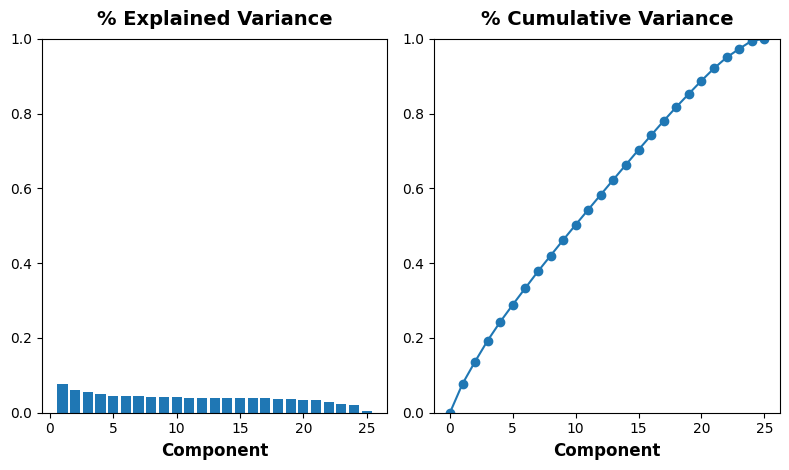

In [51]:
plot_variance(pca)

In [53]:
mi_scores = make_mi_scores(X_pca, y_energy, discrete_features=False)
mi_scores

pca4     0.303086
pca0     0.295480
pca14    0.248142
pca24    0.235342
pca22    0.209703
pca1     0.209439
pca7     0.206113
pca5     0.191880
pca16    0.168341
pca15    0.168237
pca10    0.152901
pca11    0.145607
pca6     0.144577
pca9     0.142550
pca19    0.138140
pca3     0.129245
pca12    0.124304
pca17    0.123975
pca8     0.122718
pca2     0.117971
pca13    0.113320
pca20    0.107934
pca18    0.106258
pca21    0.103865
pca23    0.097209
Name: MI Scores, dtype: float64

In [58]:
stats.pearsonr(X_pca['pca0'],X_pca['pca4'] )

PearsonRResult(statistic=7.235152147538892e-16, pvalue=0.9999999999999768)

In [61]:
# ajout de pca14 à X_energy
X_energy['PC1'] =X_pca['pca1'].values
X_energy['PC4'] =X_pca['pca4'].values

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_11576\4111145773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_energy['PC1'] =X_pca['pca1'].values
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_11576\4111145773.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_energy['PC4'] =X_pca['pca4'].values


## 4.1 train test séparation

In [64]:
X_train_energy, X_test_energy , y_train_energy, y_test_energy = train_test_split(X_energy,y_energy,test_size=0.2, random_state=12)

## 4.2 target encoding ??

In [63]:
from category_encoders import MEstimateEncoder

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["Neighborhood_northeast"], m=5.0)

# Fit the encoder on the encoding split.
encoder.fit(X_train_energy, y_train_energy)

# Encode the Zipcode column to create the final training data
X_train_energy_encoded = encoder.transform(X_train_energy)
X_test_energy_encoded = encoder.transform(X_test_energy)

## 4.3 model et predictions

In [65]:
rf = RandomForestRegressor()
param_rf = {'n_estimators':[i for i in range(1,20,1)],
           'max_depth':[i for i in range(1,10,1)]}
regr = GridSearchCV(rf,param_grid=param_rf,scoring='r2',cv=5,refit=True)
regr.fit(X_train_energy,y_train_energy)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19]},
             scoring='r2')

In [ ]:
# rs = 12 : 0.7164 ( sans target & pca14); 0.73 avec (NumberofBuildings encoded)
# rs = 20 : 0.36 ( "decennie + nbr buildings") , 0.41
# rs = 42 : 0.57( sans target & pca14), 0.62(pca14), 0.632(target + pca 14)

In [66]:
regr.score(X_train_energy,y_train_energy)

0.9411796934392317

In [67]:
params = regr.best_params_
params

{'max_depth': 9, 'n_estimators': 15}

In [68]:
final_rf = RandomForestRegressor(n_estimators = params['n_estimators'],max_depth=params['max_depth'])
final_rf.fit(X_train_energy,y_train_energy)
metrics.r2_score(y_test_energy,final_rf.predict(X_test_energy))

0.64809420812815

In [ ]:
res_energy = pd.DataFrame(y_test_energy)
res_energy['preds'] = final_rf.predict(X_test_energy)
res_energy['diff'] = res_energy.apply(lambda x : x['preds'] - x[0] , axis =1 )
plt.plot(res_energy['diff'])

In [ ]:
plt.plot(y_test_energy)

In [ ]:
plt.plot(y_train_energy)